# <center> Predicting Donors Choose</center>

--------

# Introduction
*This notebook will use features designed more for LGBM:*
- label encoding
- seperate enviroment

## Imports

https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html

In [70]:
import gc
import numpy as np
import pandas as pd
import os
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm_notebook

In [71]:
import lightgbm as lgb

In [72]:
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

In [73]:
#Am I using the kaggle test set
kaggle = False

#Am I making simulating variable situations to be tested on. 
sim = True

#Kaggle & Sim use 'test' so dont use both

In [112]:
train = pd.read_csv('./Input/train.csv', low_memory=False, index_col='id')
if kaggle: 
    if sim == False:
        test = pd.read_csv('./Input/test.csv', low_memory=False, index_col='id')

res = pd.read_csv('./Input/resources.csv', low_memory=False, index_col='id')

In [113]:
#train = train[:10000]
#test = test[:2500]

### Simulated Data

In [76]:
#We want to simulate how an unsuccessful project could have had a higher rate of success.
#So we will pull out an instance that we know has failed, and delete it from our training set,
#and generate modified data to see under which conditions it might have had the highest rate of success

In [77]:
def make_sim(n='p081434'):
    """
    Makes a semi-brute forced dataset based off the entry n, with variable:
    Months (jan-dec), 
    Pronouns (not teacher or dr), 
    Previous Entries(0:30),
    to see what combination may have a higher success rate
    """
    test = pd.DataFrame(train.loc[n]).transpose()
    del test['project_is_approved']
    
    change_dict = {"prefix":['Mrs.','Ms.','Mr.'],
        "date":['2017-01-26','2017-02-26','2017-03-26','2017-04-26','2017-05-26','2017-06-26',
        '2017-07-26','2017-08-26','2017-09-26','2017-10-26','2017-11-26','2017-12-26',],
        "prev" : [x for x in range(0,10)]}

    for i in range(1000):
        test.loc[n+str(i)] = test.loc[n].transpose()
        test.set_value(n+str(i),'teacher_prefix',np.random.choice(change_dict['prefix']))
        test.set_value(n+str(i),'project_submitted_datetime',np.random.choice(change_dict['date']))
        test.set_value(n+str(i),'teacher_number_of_previously_posted_projects',np.random.choice(change_dict['prev']))
        
    test.index.rename = 'id'
    return(test)

In [78]:
#making a dataset which has variable situations that 'p039654' may be under
if sim:
    test = make_sim('p081434')
    train = train.drop('p081434',axis=0)
    del make_sim

/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## Preprocessing

### 1.1 Resource Intergration
Here we evaluate how much each project/proposal will cost and/or how big they are

In [79]:
train.columns

Index(['teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [80]:
res['cost'] = res['quantity'] * res['price']
res_agg = res.groupby('id').agg({'description': ['nunique'], 'quantity': ['sum'], 'cost': ['mean', 'sum','median','max','min']})
res_agg.columns = ['unique_items','total_quantity', 'mean_cost', 'total_cost','median_cost','most_exp_cost','least_exp_cost']
res_agg.reset_index(inplace=True)

#description was dropped because the description of the project should not have an effect on its liklihood of success

In [81]:
train = train.merge(res_agg, left_index=True, right_on='id')
if (kaggle | sim): 
    if sim : 
        for i in res_agg.columns:
            if i != 'id':
                test[i] = res_agg[res_agg['id']=='p081434'][i].values[0]
    else:
        test =  test.merge(res_agg, left_index=True, right_on='id')

In [82]:
del res_agg
del res

### 1.2 Preprocessing of features

In [83]:
eg = train.school_state.value_counts()

In [84]:
eg.index.values

array(['CA', 'TX', 'NY', 'FL', 'NC', 'IL', 'GA', 'SC', 'MI', 'PA', 'IN',
       'MO', 'OH', 'MA', 'LA', 'WA', 'OK', 'NJ', 'AZ', 'VA', 'WI', 'AL',
       'TN', 'UT', 'CT', 'MD', 'NV', 'MS', 'KY', 'OR', 'MN', 'CO', 'AR',
       'ID', 'IA', 'KS', 'NM', 'DC', 'HI', 'WV', 'ME', 'DE', 'NH', 'AK',
       'SD', 'NE', 'RI', 'MT', 'ND', 'WY', 'VT'], dtype=object)

Text(0.5,1,'Top Application Frequencies By State')

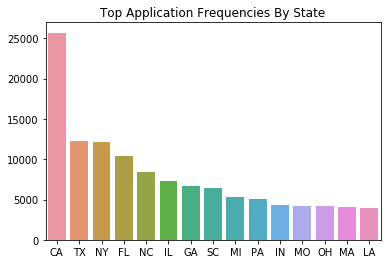

In [85]:
sns.barplot(eg.index[:15].values,eg[:15].values)#,eg)
plt.title('Top Application Frequencies By State')

In [86]:
train

,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,...,teacher_number_of_previously_posted_projects,project_is_approved,id,unique_items,total_quantity,mean_cost,total_cost,median_cost,most_exp_cost,least_exp_cost
36501,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,...,26,1,p036502,2,6,449.970000,899.94,449.970,449.97,449.97
39564,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,...,1,0,p039565,1,20,400.000000,400.00,400.000,400.00,400.00
233822,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,...,5,1,p233823,1,1,469.990000,469.99,469.990,469.99,469.99
185306,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",...,16,0,p185307,5,5,136.894000,684.47,126.870,354.99,18.95
13779,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,...,42,1,p013780,1,2,711.000000,711.00,711.000,711.00,711.00
63373,403c6783e9286e51ab318fba40f8d729,Mrs.,DE,2016-11-05 10:01:51,Grades PreK-2,"Applied Learning, Literacy & Language","Character Education, Literature & Writing",Need to Reach Our Virtual Mentors!!!,My kids tell me each day that they want to mak...,I started a program called Telementoring in ho...,...,0,1,p063374,2,7,363.680000,727.36,363.680,415.60,311.76
103284,4e156c5fb3eea2531601c8736f3751a7,Mrs.,MO,2016-08-31 00:30:43,Grades PreK-2,Health & Sports,Health & Wellness,Active Kindergartners,Kindergarten is the new first grade. My studen...,With balance discs and stools as flexible seat...,...,1,1,p103285,2,6,207.010000,414.02,207.010,384.04,29.98
181780,c71f2ef13b4bc91afac61ca8fd4c0f9f,Mrs.,SC,2016-08-03 13:26:01,Grades PreK-2,"Applied Learning, Literacy & Language","Early Development, Literature & Writing",Fabulous Firsties-Wiggling to Learn!,First graders are fantastic! They are excited ...,First graders love learning! We need 6 wiggle-...,...,0,1,p181781,1,6,414.780000,414.78,414.780,414.78,414.78
114988,b580c11b1497a0a67317763b7f03eb27,Ms.,IN,2016-09-13 22:35:57,Grades 6-8,Math & Science,Mathematics,Wobble Chairs Help Fidgety Kids Focus,My seventh graders dream big. They can't wait ...,I have used alternative seating in my classroo...,...,13,1,p114989,1,4,319.800000,319.80,319.800,319.80,319.80
191409,2071fb0af994f8f16e7c6ed0f35062a1,Mrs.,IL,2016-09-24 18:38:59,Grades PreK-2,Literacy & Language,Literacy,Snuggle Up With A Good Book,I teach first grade in a small farming town in...,There is nothing better than snuggling up with...,...,12,1,p191410,1,2,119.760000,119.76,119.760,119.76,119.76


#### EDA

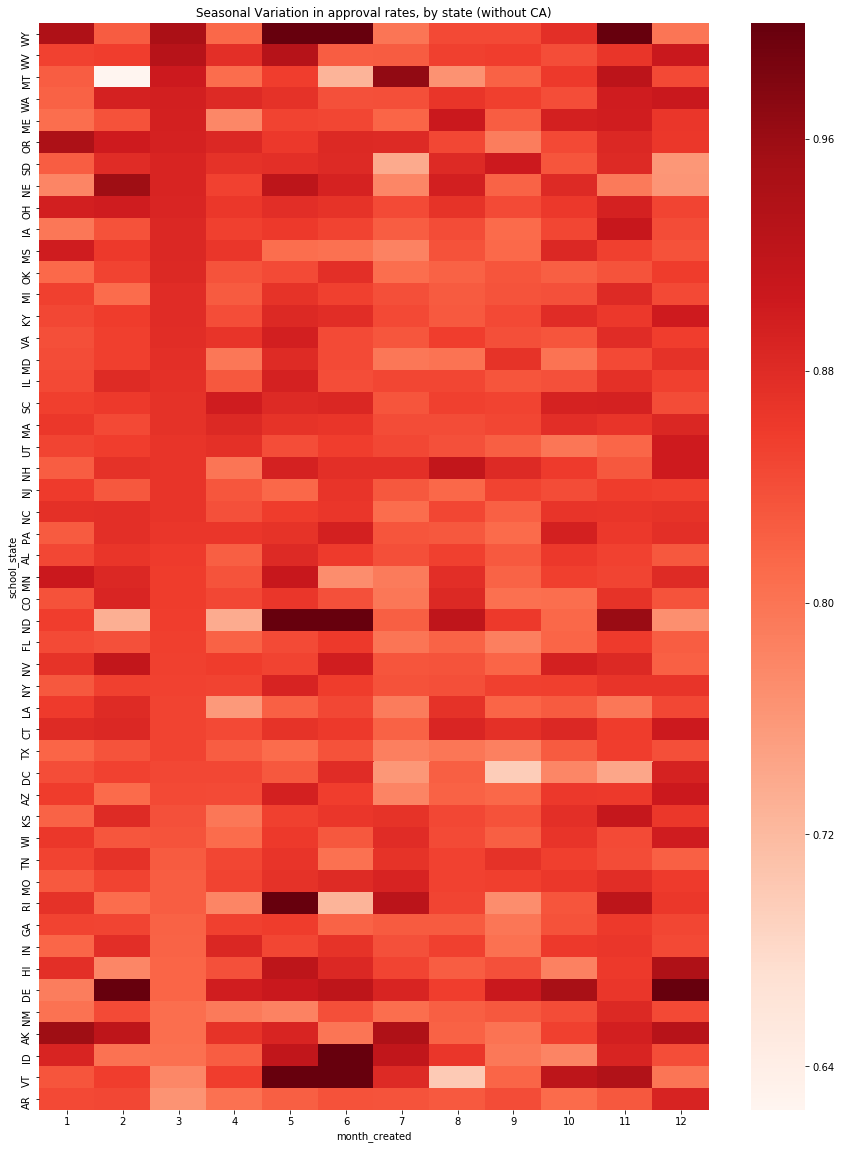

In [87]:
train["project_submitted_datetime"] = pd.to_datetime(train["project_submitted_datetime"])
train["month_created"] = train["project_submitted_datetime"].dt.month
train["year_created"] = train["project_submitted_datetime"].dt.year
loan = train.groupby(['school_state', 'month_created'])['project_is_approved'].mean().unstack()
loan = loan.sort_values([3], ascending=False)
f, ax = plt.subplots(figsize=(15, 20)) 
loan = loan.fillna(0)
loan = loan.drop('CA',axis=0)
temp = sns.heatmap(loan, cmap='Reds')
plt.title('Seasonal Variation in approval rates, by state (without CA)')
plt.show()

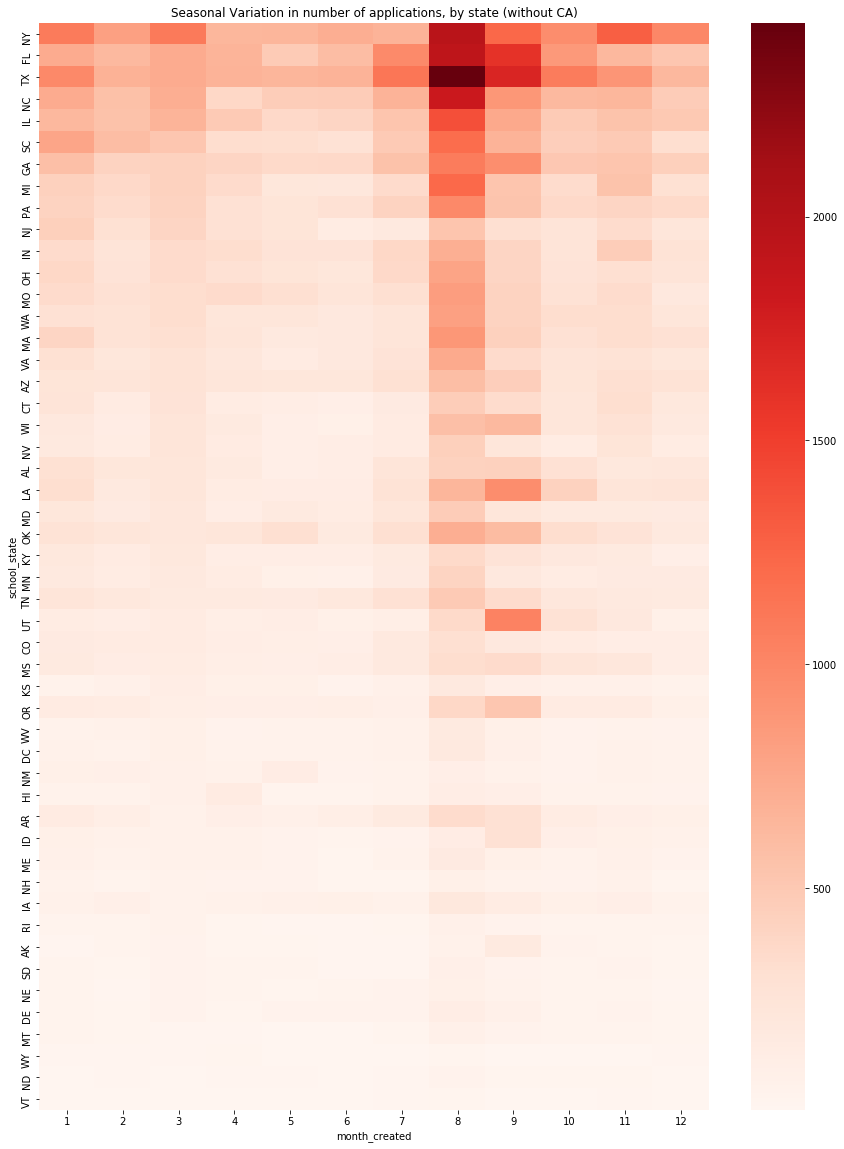

In [88]:
loan = train.groupby(['school_state', 'month_created'])['total_cost'].count().unstack()
loan = loan.sort_values([3], ascending=False)
f, ax = plt.subplots(figsize=(15, 20)) 
loan = loan.fillna(0)
loan = loan.drop('CA',axis=0)
temp = sns.heatmap(loan, cmap='Reds')
plt.title('Seasonal Variation in number of applications, by state (without CA)')
plt.show()

In [89]:
del train['month_created'], train['year_created']

In [90]:
#gen_mon = train.groupby(['datetime_month','gender'])['project_is_approved'].mean().reset_index()
#prev_mon = train.groupby('teacher_number_of_previously_posted_projects')['project_is_approved'].mean().reset_index()

#bins = pd.cut(train['teacher_number_of_previously_posted_projects'], [0, 25, 50, 75, 100, 125, 150])
#pros = train.groupby(bins)['project_is_approved'].agg('mean')

In [91]:
#sns.barplot(pros.index,pros)
#plt.title('Frequent Applicants')
#plt.xlabel("Teacher's Previous Postings")
#plt.ylabel("Mean Approvals")

In [92]:
#train.project_is_approved.value_counts()

In [93]:
#sns.lmplot(x="datetime_month", y="project_is_approved", hue="gender", 
#           data=gen_mon[gen_mon['gender']!='Unk'], 
#           order=3,ci=80)
#plt.title('Approval rate, by month, by gender (ci:90)')

In [94]:
#del gen_mon
#del prev_mon

In [95]:
gc.collect()

8350

#### Cat Preprocessing

There are 51 States, because of 50 + DC

In [96]:
train.isnull().sum()[train.isnull().sum()>0]

teacher_prefix          4
project_essay_3    175705
project_essay_4    175705
dtype: int64

In [97]:
train.teacher_prefix[train.teacher_prefix.isnull()] = 'Teacher'
try: 
    test.teacher_prefix[test.teacher_prefix.isnull()] = 'Teacher'
except:
    pass

/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


fill na did not work

In [98]:
def date_prep(train):
    train['project_submitted_datetime'] = pd.to_datetime(train['project_submitted_datetime'])
    train['datetime_year'] = train['project_submitted_datetime'].dt.year
    train['datetime_month'] = train['project_submitted_datetime'].dt.month
    return(train)
def gender_features(train):
    conditions = [(train.teacher_prefix == 'Mr.'), 
                  (train.teacher_prefix == 'Mrs.') | (train.teacher_prefix == 'Ms.')]
    choices = ['Male', 'Female']
    train['gender'] = np.select(conditions, choices, default='Unk')
    return(train)

In [99]:
date_prep(train)
if (kaggle | sim): date_prep(test)
del date_prep

In [100]:
train = gender_features(train)
if (kaggle | sim): 
    test = gender_features(test)
    del test['project_submitted_datetime'], test['project_subject_subcategories']

del train['project_submitted_datetime'], train['project_subject_subcategories']
del gender_features

In [101]:
gc.collect()

66

##### Encoding labels

In [115]:
train.loc['p081434']

teacher_id                                                       17563b7d138a9ca1e7308f0f480e7d09
teacher_prefix                                                                                Ms.
school_state                                                                                   NY
project_submitted_datetime                                                    2016-12-06 21:19:44
project_grade_category                                                              Grades PreK-2
project_subject_categories                                         Health & Sports, Special Needs
project_subject_subcategories                                    Health & Wellness, Special Needs
project_title                                          Seating Like a Boss- Our 21st Century Room
project_essay_1                                 \"Great job buddy!\" is something I hear every...
project_essay_2                                 In order to promote essential learning skills ...
project_essay_3     

In [102]:
simm = pd.DataFrame()

In [107]:
simm['test'] = siim['pred']

In [111]:
simm.sort_values('test',ascending=False)

,test,gender,teacher_prefix,school_state,datetime_year,datetime_month,project_grade_category
0,0.642415,Male,Mr.,NY,2017,5,Grades PreK-2
2,0.642415,Male,Mr.,NY,2017,6,Grades PreK-2
3,0.642415,Male,Mr.,NY,2017,5,Grades PreK-2
4,0.642415,Male,Mr.,NY,2017,5,Grades PreK-2
5,0.642415,Male,Mr.,NY,2017,6,Grades PreK-2
6,0.642415,Male,Mr.,NY,2017,5,Grades PreK-2
1,0.642415,Male,Mr.,NY,2017,6,Grades PreK-2
29,0.641659,Male,Mr.,NY,2017,3,Grades PreK-2
23,0.641659,Male,Mr.,NY,2017,10,Grades PreK-2
24,0.641659,Male,Mr.,NY,2017,2,Grades PreK-2


In [105]:
# Because of trees do no need onehot encoding, label encoding is used
cols  = ['gender',
        'teacher_prefix', 
        'school_state',
        'datetime_year',
        'datetime_month',
        'project_grade_category']

for c in tqdm_notebook(cols):
    encod = LabelEncoder()
    encod.fit(train[c].astype(str))
    train[c] = encod.transform(train[c].astype(str))
    simm[c] = encod.inverse_transform(siim[c])
    if (kaggle | sim):        
        test[c] = encod.transform(test[c].astype(str))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [60]:
siim = pd.read_csv("/Users/Nahel/Desktop/siim.csv")

In [61]:
del siim['Unnamed: 0']

In [62]:
for c in tqdm_notebook(cols):
    siim[c] = encod.inverse_transform(siim[c])

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ValueError: y contains new labels: [34]

In [65]:
gen = encod.inverse_transform(siim['gender'])
pre = encod.inverse_transform(siim['teacher_prefix'])


/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/Nahel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [69]:
pre

array(['Grades 6-8', 'Grades 6-8', 'Grades 6-8', ..., 'Grades PreK-2',
       'Grades PreK-2', 'Grades 9-12'], dtype=object)

#### Num Preprocessing

In [182]:
num_features  = ['teacher_number_of_previously_posted_projects',
                 'total_quantity', 'mean_cost', 'total_cost','unique_items']

In [183]:
SS = StandardScaler()
train[num_features] = SS.fit_transform(train[num_features])
if (kaggle | sim): test[num_features] = SS.transform(test[num_features])

In [184]:
del num_features, StandardScaler, SS

In [185]:
gc.collect()

14

#### Text Preprocessing

In [186]:
from nltk.corpus import stopwords
all_stopwords = [x for x in 'abcdefghijklmnopqrstuvwxyz']
for j in ['student','students','education',]:
    all_stopwords.append(j)
all_stopwords += stopwords.words("english")

In [187]:
#import gensim
def scrub(text):
    text = text.strip().lower()
    text = re.sub('\W+',' ', text)    
    text = re.sub(r'_', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\:', ' ', text)
    text = re.sub(r'\+', ' ', text)
    text = re.sub(r'\=', ' ', text)
    text = re.sub(r'(\")', ' ', text)
    text = re.sub(r'(\r)', ' ', text)
    text = re.sub(r'(\n)', ' ', text)
    text = re.sub(r'(\\)', ' ', text)
    text = re.sub('n t ','n\'t ', text)
    text = re.sub(' re ',' are ', text)
    text = re.sub(r'(\r\n)', ' ', text)
    text = re.sub(r'\"\"\"\"', ' ', text)
    text = re.sub(' i m ',' i\'m ', text)
    return(text)
def swords(text):
    text = ' '.join([word for word in text.split() if word not in (all_stopwords)])
    return(text)

##### Project Category Preprocessing

In [188]:
def yup(text):
    text =[word for word in text.split(',')]
    text =[word.strip() for word in text]
    return(text)

In [189]:
yar = train.project_subject_categories.apply(lambda x:yup(x))
p = pd.get_dummies(yar.apply(pd.Series).stack()).sum(level=0).reset_index(drop=True)
del p['Warmth']

In [190]:
k = p.join(train.reset_index(drop=True).project_is_approved)

In [191]:
k = k.groupby('project_is_approved').sum().transpose()
k['avg'] = k[1]/(k[1] + k[0])
k['count'] = (k[1] + k[0])

In [192]:
k['percent_of_total'] = k['count']/len(train)

In [194]:
k = k.sort_values('count',ascending=False)

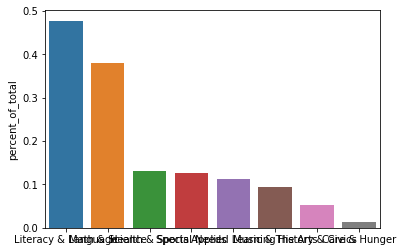

In [195]:
sns.barplot(k.index,k.percent_of_total)

In [211]:
train = train.reset_index(drop=True)
train = train.merge(p,left_index=True,right_index=True)

In [212]:
if (kaggle | sim):
    yar = test.project_subject_categories.apply(lambda x:yup(x))
    for i in p.columns:
        test[i]=0
    p = pd.get_dummies(yar.apply(pd.Series).stack()).sum(level=0).reset_index(drop=True)
    if p.columns.contains('Warmth'):
        del(p['Warmth'])
    for i in p.columns:
        test[i] = p[i]
    del test['project_subject_categories']

In [213]:
del train['project_subject_categories'], p, yar

In [ ]:
train.

##### Essay Preprocessing

  
#### Before May 17th, 2016:

- project_essay_1: "Introduce us to your classroom"
- project_essay_2: "Tell us more about your students"
- project_essay_3: "Describe how your students will use the materials you're requesting"
- project_essay_4: "Close by sharing why your project will make a difference"

#### May 17th, 2016 and beyond:

- project_essay_1: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
- project_essay_2: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

#### Plan
- Combine essay_1 and essay_2 before May 17th to make "student_description" and use essay_1 after May 17th directly
- Combine essay_3 and essay_4 before May 17th to make "project_description" and use essay_2 after May 17th directly

In [214]:
def essay_convert(train):
    # Making the First essay : student_description
    train['student_description']=train['project_essay_1']
    train.loc[train.project_essay_3.notnull(),'student_description']=train.loc[train.project_essay_3.notnull(),'project_essay_1']+train.loc[train.project_essay_3.notnull(),'project_essay_2']

    # Making the second essay : project_description
    train['project_description']=train['project_essay_2']
    train.loc[train.project_essay_3.notnull(),'project_description']=train.loc[train.project_essay_3.notnull(),'project_essay_3']+train.loc[train.project_essay_3.notnull(),'project_essay_4']

    # Removing original essays
    del train['project_essay_1']
    del train['project_essay_2']
    del train['project_essay_3']
    del train['project_essay_4']
    return(train)

In [215]:
essay_convert(train)
if (kaggle | sim): essay_convert(test)
gc.collect()

del essay_convert

##### Scrub Text Features

In [104]:
text_features = ['project_title', 'project_resource_summary',
                'project_description', 'student_description']

In [105]:
for j in tqdm_notebook(text_features):
    n_col = 'processed_'+j
    train[n_col] = train[j].apply(lambda x: scrub(x)).apply(lambda x: swords(x))
    if (kaggle | sim): test[n_col] = test[j].apply(lambda x: scrub(x)).apply(lambda x: swords(x))

gc.collect()
for i in text_features:
    del train[i]
    if (kaggle | sim): del test[i]

del stopwords, all_stopwords, text_features, swords

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [106]:
gc.collect()

56

## Word Clouds?

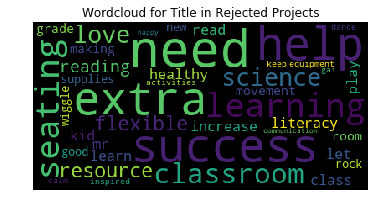

In [107]:
wordcloud = WordCloud(
                          background_color='black',
                          max_words=40,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(train[train.project_is_approved==0].processed_project_title))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title('Wordcloud for Title in Rejected Projects')
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=2400)

In [151]:
train.columns[:25]

Index(['teacher_id', 'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'id', 'unique_items', 'total_quantity',
       'mean_cost', 'total_cost', 'median_cost', 'most_exp_cost',
       'least_exp_cost', 'Applied Learning', 'Care & Hunger',
       'Health & Sports', 'History & Civics', 'Literacy & Language',
       'Math & Science', 'Music & The Arts', 'Special Needs',
       'processed_project_title_contains_-21st',
       'processed_project_title_contains_-21st century',
       'processed_project_title_contains_-active',
       'processed_project_title_contains_-art',
       'processed_project_title_contains_-book',
       'processed_project_title_contains_-books'],
      dtype='object')

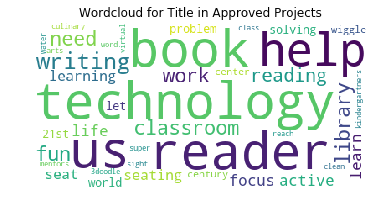

In [108]:
wordcloud = WordCloud(
                          background_color='white',
                          max_words=40,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(train[train.project_is_approved==1].processed_project_title))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Wordcloud for Title in Approved Projects')
plt.show()
fig.savefig("word1.png", dpi=2400);

In [109]:
del wordcloud

## Modeling

### Tfidf & X,y Assignment

In [110]:
gc.collect()

2445

In [111]:
cols = [
    'processed_project_title',
    'processed_project_resource_summary', 
    'processed_project_description',
    'processed_student_description']

In [112]:
for i in cols:
    print("Average length in {} is {} words".format(i,str(round(train[i].str.len().mean()))))

Average length in processed_project_title is 25 words
Average length in processed_project_resource_summary is 81 words
Average length in processed_project_description is 523 words
Average length in processed_student_description is 414 words


In [113]:
n_features = [
    100, 
    100, 
    2000,
    2000]

In [145]:
gc.collect()

528

In [115]:
for c_i, c in tqdm_notebook(enumerate(cols)):
    tfidf = TfidfVectorizer(
        ngram_range=(1,2),
        max_features=n_features[c_i])

    tfidf.fit(train[c])

    tfidf_train = np.array(tfidf.transform(train[c].values).toarray(), dtype=np.float16)
    for i in range(n_features[c_i]):
        train[c + '_contains_-' + tfidf.get_feature_names()[i]] = tfidf_train[:, i]
    if (kaggle | sim):
        tfidf_test = np.array(tfidf.transform(test[c].values).toarray(), dtype=np.float16)
        for i in range(n_features[c_i]):
            test[c + '_contains_-' + tfidf.get_feature_names()[i]] = tfidf_test[:, i]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [122]:
for i in cols:
    del train[i]
    if (kaggle | sim): del test[i]

if (kaggle|sim): del tfidf_test
del tfidf_train, tfidf

In [125]:
drop_cols = ['project_is_approved','id','teacher_id']

X = train.drop(drop_cols, axis=1)
y = train['project_is_approved']
feature_names = list(X.columns)

In [134]:
test = test.drop('teacher_id',axis=1)

In [135]:
X.shape[1] == test.shape[1]

True

In [ ]:
#del train

In [137]:
#if running demo, uncomment this and change test['id'].vaues -> test['index'].values
if (kaggle|sim): test = test.reset_index(drop=True)

In [139]:
X_kaggle = test.drop(drop_cols, axis=1, errors='ignore')
if kaggle: id_test = test['id'].values

### Grid Search over LGBM for best params without training

In [ ]:
model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    is_unbalance=True, 
    random_state=10,
    bagging_freq=5,
    learning_rate=0.025,
    objective= 'binary', 
    metric= 'auc',
    min_child_samples=5,
    verbose=1,
    n_jobs=-1)

In [ ]:
params_opt = {'num_leaves': [x for x in range(20,31,1)],
            'max_depth': [x for x in range(15,21)],
            'feature_fraction': [x / 1000.0 for x in range(825,900,25)],
            'bagging_fraction': [x / 1000.0 for x in range(825,900,25)],
            'lambda_l2' : [x / 100.0 for x in range(0,110,10)],}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rs = RandomizedSearchCV(
    model, 
    params_opt, 
    n_iter=5,
    scoring='roc_auc',
    verbose=5,
    cv=4,
    n_jobs=-1)

rs.fit(X,y)

In [ ]:
rs.best_score_

In [ ]:
rs.best_params_

In [ ]:
train.head()

### Training Best LGBM

In [146]:
# Build the model
cnt = 0
n_splits = 5
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=42)

for train_index, valid_index in kf.split(X):
    print('Fold {}/{}'.format(cnt + 1, n_splits))
    
    params = {'is_unbalance': True, 
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.025,
        'bagging_freq': 5,
        'verbose': 1,
        'min_gain_to_split': 3,
        'min_child_samples' : 5,

        'num_threads': 1,
        'lambda_l2': 0.08,              
        'bagging_fraction': 0.85,
        'feature_fraction': 0.85,
        'max_depth': 18,
        'num_leaves': 24,
    }  

    lgb_train = lgb.Dataset(
        X.loc[train_index], 
        y.loc[train_index], 
        feature_name=feature_names)

    lgb_valid = lgb.Dataset(
        X.loc[valid_index], 
        y.loc[valid_index])

    model = lgb.train(
        params, lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=10,
        verbose_eval=10,)

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(60):
            if i < len(tuples):
                print(tuples[i])
            else:
                break
    
    cnt = cnt+1

Fold 1/5
Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.726531	valid_1's auc: 0.715222
[20]	training's auc: 0.731333	valid_1's auc: 0.718738
[30]	training's auc: 0.734541	valid_1's auc: 0.721424
[40]	training's auc: 0.737221	valid_1's auc: 0.72372
[50]	training's auc: 0.74133	valid_1's auc: 0.726688
[60]	training's auc: 0.745155	valid_1's auc: 0.72969
[70]	training's auc: 0.74876	valid_1's auc: 0.732691
[80]	training's auc: 0.752519	valid_1's auc: 0.73523
[90]	training's auc: 0.756058	valid_1's auc: 0.737875
[100]	training's auc: 0.759422	valid_1's auc: 0.740406
[110]	training's auc: 0.762596	valid_1's auc: 0.742744
[120]	training's auc: 0.765562	valid_1's auc: 0.744749
[130]	training's auc: 0.768577	valid_1's auc: 0.746964
[140]	training's auc: 0.771385	valid_1's auc: 0.748977
[150]	training's auc: 0.774213	valid_1's auc: 0.751152
[160]	training's auc: 0.776652	valid_1's auc: 0.75286
[170]	training's auc: 0.778962	valid_1's auc: 0.754416
[180]	tra

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=15, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [ ]:
p = model.predict(X_kaggle, num_iteration=model.best_iteration)

In [ ]:
submit = pd.DataFrame({'id':id_test,'pred':p})

In [ ]:
submit

In [ ]:
#submit.sort_values('pred',axis=0,)

In [153]:
train.gender

AttributeError: 'DataFrame' object has no attribute 'gender'